In [1]:
# Copyright (C) 2016-2018 by Jakob J. Kolb at Potsdam Institute for Climate
# Impact Research
#
# Contact: kolb@pik-potsdam.de
# License: GNU AGPL Version 3
%matplotlib notebook
import PyDSTool as pdt
import numpy as np
import networkx as nx
from random import shuffle
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pydivest.macro_model.integrate_equations_aggregate import IntegrateEquationsAggregate as Model

In [2]:
b_ds = [round(x, 5) for x in list(np.linspace(1., 4., 21))]
kappa_cs = [round(x, 5) for x in list(np.linspace(.4, .5, 2))]
d_cs = [round(x, 5) for x in list(np.linspace(.05, .12, 8))]
es = [round(x, 5) for x in list(np.linspace(1., 51, 3))]
b_Rs = [round(x, 5) for x in list(np.linspace(.1, .5, 3))]
epss = [round(x, 5) for x in list(np.linspace(.01, .05, 3))]

selector = f'kappa_c = {kappa_cs[1]} & e = 1. &'\
           f'd_c = {d_cs[0]} & b_R = .1 & eps = {epss[0]} & b_d < 4'
columns = ['x', 'xi', 'C', 'labels', 'stability']
with pd.HDFStore('../output_data/P5/P5.h5') as store:
    df = store.select('dat', where=selector, columns=columns)

for col in df.columns[:-2]:
    df[col] = df[col].astype(float)
df = df.loc[df['C'] < 150000]
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# fig, ax = plt.subplots(nrows=1, ncols=1, projection='3d')

for b_d in df.index.levels[0]:
    df_plt = df.xs(key=b_d, level=0)
    df_lines = df_plt.set_index('xi')['C']
    # ToDo Plot 3d
    df_lines.plot(ax=ax, color='blue')
    df_lp = df_plt.loc[df_plt['labels']=='EP, LP']
    if len(df_lp['C'].values)>0:
        # ToDo Plot 3d
        df_lp.plot.scatter(x='xi', y='C', ax=ax, legend=False, color='red')


df_lp = df.loc[df['labels'] == 'EP, LP']

idx = df_lp.groupby('b_d')['C'].transform(max) == df_lp['C']
df_lp_max = df_lp[idx][['xi', 'C']]
df_lp_max.columns = ['xi', 'Limit Point \ncurve']
# ToDo Plot 3d
df_lp_max.set_index('xi').plot(ax=ax, color='red')

idx = df_lp.groupby('b_d')['C'].transform(min) == df_lp['C']
# ToDo Plot 3d
df_lp[idx][['xi', 'C']].set_index('xi').plot(ax=ax, color='red', legend=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


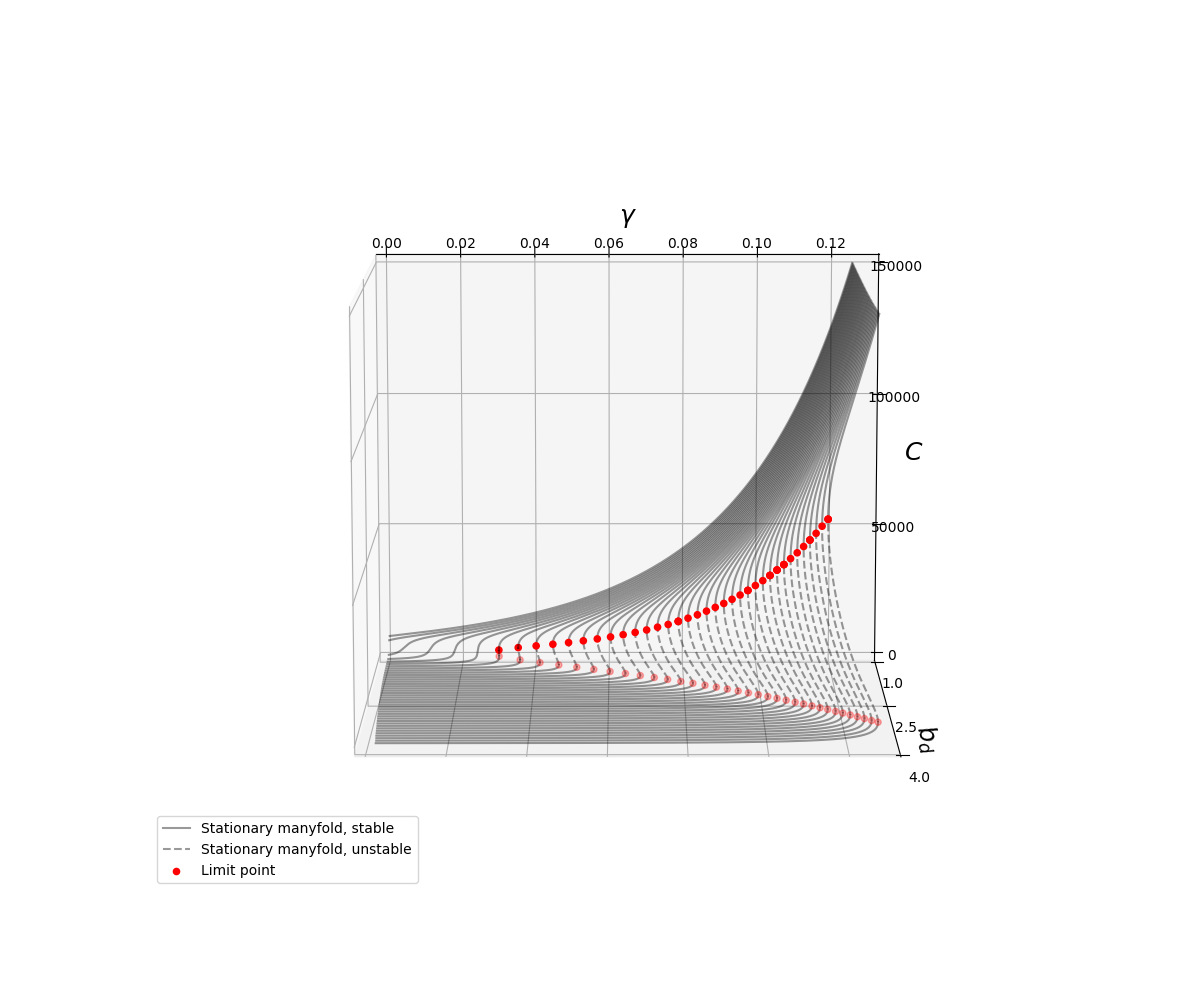

In [22]:
# import 3d plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

# create 3d figure and axes
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

def plotit(df, b_d, ax, style):
    df_lines = df.set_index('xi')['C']
    x = df_lines.index.values
    y = df_lines.values
    z = b_d
    ax.plot(x, y, z, style, color='black', alpha=0.4, zdir='z')

# plot for each value of b_d
for b_d in df.index.levels[0]:
    
    # select data according to b_d value
    df_plt = df.xs(key=b_d, level=0)
    
    # if there are limit points, (labelled with 'EP, LP'), plot stationary manyfold in parts
    # with style according to stability
    C_lps = df_plt.loc[df_plt['labels']=='EP, LP', 'C'].values
    if len(C_lps) > 0:
        C_cut = C_lps[0]
        plotit(df_plt.loc[(df_plt['stability']=='S') & (df_plt['C'] < C_cut)], b_d, ax, '-')
        plotit(df_plt.loc[(df_plt['stability']=='S') & (df_plt['C'] > C_cut)], b_d, ax, '-')
        plotit(df_plt.loc[(df_plt['stability']=='N')], b_d, ax, '--')
        
    # else, plot it in one piece
    else:
        plotit(df_plt, b_d, ax, '-')
    
    # select data for limit points and plot them as red dots.
    df_lp = df_plt.loc[df_plt['labels']=='EP, LP']
    if len(df_lp['C'].values)>0:
        x = df_lp['xi'].values
        y = df_lp['C'].values
        z = b_d
        ax.scatter(x, y, z, color='red', zdir='z')
        
# generate legend
x, y, z = (-10, -10, -10)
xs, ys = np.zeros((2, 10))
ax.plot(xs, ys, z, '-', color='black', alpha=0.4, label='Stationary manyfold, stable')
ax.plot(xs, ys, z, '--', color='black', alpha=0.4, label='Stationary manyfold, unstable')
ax.scatter(x, y, z, color='red', zdir='z', label='Limit point')

plt.legend(loc=3)

# set axis ticks and limits
ax.set_zticks([1, 2.5, 4])
ax.set_zlim([1, 4])
ax.set_yticks([0, 50000, 100000, 150000])
ax.set_ylim([0, 150000])
ax.set_xlim([0., 0.13])

# set rotation
ax.azim = -90
ax.elev = 100

# set axis labels. would like to ratete the, but doesn't seem to work..
ax.set_xlabel(r'$\gamma$', fontsize=18)
ax.set_ylabel(r'$C$', fontsize=18)
ax.set_zlabel(r'$b_d$', fontsize=18)

# ax.show()
# df_lp = df.loc[df['labels'] == 'EP, LP']

# idx = df_lp.groupby('b_d')['C'].transform(max) == df_lp['C']
# df_lp_max = df_lp[idx][['xi', 'C']]
# df_lp_max.columns = ['xi', 'Limit Point \ncurve']
# # ToDo Plot 3d
# df_lp_max.set_index('xi').plot(ax=ax, color='red')

# idx = df_lp.groupby('b_d')['C'].transform(min) == df_lp['C']
# # ToDo Plot 3d
# df_lp[idx][['xi', 'C']].set_index('xi').plot(ax=ax, color='red', legend=False)

fig.savefig('cusp.pdf')